In [95]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn import tree
from anytree import Node, RenderTree
import random
import math
from sklearn.naive_bayes import GaussianNB
import scipy.stats

In [96]:
titanic = pd.read_csv('titanic/combites.csv')

In [97]:
def categorize_company(df):
    
    # 0 if alone, 1 if only with siblings/spouse, 2 if only with parent/children, 3 if with both (number of people is disregarded)
    conditions = [(df.Parch + df.SibSp == 0), (df.Parch == 0) & (df.SibSp > 0), (df.Parch > 0) & (df.SibSp ==0),
                  (df.Parch > 0) & (df.SibSp > 0)]
    categories = [0, 1, 2, 3]
    
    # create company attribute
    df["Company"] = np.select(conditions, categories)
    
    # count companions
    df["Companions"] = df.SibSp + df.Parch
    
    # create alone attribute (1 if alone, 0 if not)
    df["Alone"] = np.where(df.Parch + df.SibSp > 0, 0, 1)
        
categorize_company(titanic)

print(titanic.head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Dataset CabinD CabinEO  \
0      0         A/5 21171   7.2500   NaN        S   train      U       u   
1      0          PC 17599  71.2833   C85        C   train      C       o   
2      0  STON/O2. 3101282   7.9250   NaN        S   train      U       u   
3      0    

In [98]:
# subtract title from name

def format_name(df):
    
    # determine last name (for family indication)
    df['Lname'] = df.Name.apply(lambda x: x.split(', ')[0])
    
    # determine prefix
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(', ')[1])
    df['NamePrefix'] = df.NamePrefix.apply(lambda x: x.split(' ')[0].split('.')[0].strip())
    
    # dictionary of all options to categories
    normalized_titles = {
    "Capt":       5,
    "Col":        5,
    "Major":      5,
    "Jonkheer":   4,
    "Don":        4,
    "Sir" :       4,
    "Dr":         5,
    "Rev":        5,
    "the":        4,
    "Dona":       4,
    "Mme":        1,
    "Mlle":       2,
    "Ms":         1,
    "Mr" :        0,
    "Mrs" :       1,
    "Miss" :      2,
    "Master" :    3,
    "Lady" :      4
    }
    
    # assign title to each passenger
    df["NamePrefix"] = titanic.NamePrefix.map(normalized_titles).astype(int)
    return df   


format_name(titanic)
# print(titanic.head())
print(titanic["NamePrefix"])

0       0
1       1
2       2
3       1
4       0
5       0
6       0
7       3
8       1
9       1
10      2
11      2
12      0
13      0
14      2
15      1
16      3
17      0
18      1
19      1
20      0
21      0
22      2
23      0
24      2
25      1
26      0
27      0
28      2
29      0
       ..
1279    0
1280    3
1281    0
1282    1
1283    3
1284    0
1285    0
1286    1
1287    0
1288    1
1289    0
1290    0
1291    2
1292    0
1293    2
1294    0
1295    0
1296    0
1297    0
1298    0
1299    2
1300    2
1301    2
1302    1
1303    2
1304    0
1305    4
1306    0
1307    0
1308    3
Name: NamePrefix, Length: 1309, dtype: int32


In [99]:
# fill in missing ages based on age, title and class
def categorize_age(df):
    
    # get values of sex, class and title
    specAge = titanic.groupby(["Sex", "Pclass", "NamePrefix"])
    
    # determine the median age of each sex-class-title combinations
    specAge.Age.median()
    
    # fill in median age of sex-class-title combination when age data is missing
    titanic.Age = specAge.Age.apply(lambda x: x.fillna(x.median()))
    
    # group dataset in age categories
    bins = (0, 4, 12, 18, 25, 35, 60, 100)
    agename = ["0-4", "4-12", "12-18", "18-25", "25-35", "35-60", "60-100"]
    df["Agegroup"] = pd.cut(df.Age, bins, labels = agename)
    
categorize_age(titanic)
print(titanic.head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare  ... Dataset CabinD CabinEO ColumnEmpty  \
0      0         A/5 21171   7.2500  ...   train      U       u           1   
1      0          PC 17599  71.2833  ...   train      C       o           0   
2      0  STON/O2. 3101282   7.9250  ...   train      U       u           1   
3   

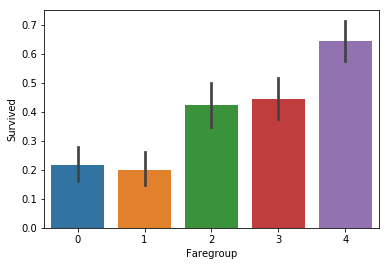

In [100]:
def categorize_fare(df):
    
    df["Faregroup"] = pd.qcut(df.Fare, 5, labels = [0, 1, 2, 3, 4])
    df["Faregroup"] = df["Faregroup"].fillna(2)
    
categorize_fare(titanic)
titanic.tail()

sns.barplot(x = "Faregroup", y = "Survived", data = titanic)

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare  ... CabinD CabinEO ColumnEmpty Company  \
0      0         A/5 21171   7.2500  ...      U       u           1       1   
1      0          PC 17599  71.2833  ...      C       o           0       1   
2      0  STON/O2. 3101282   7.9250  ...      U       u           1       0   
3   

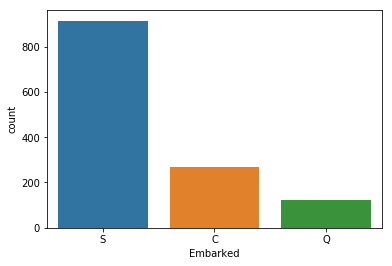

In [101]:
sns.countplot(x = "Embarked", data = titanic)

def missing_embarked(df):
    likely_embarked = df.Embarked.mode()[0]
    df['Embarked'] = df.Embarked.fillna(likely_embarked)
    
def missing_cabineo(df):
    df['CabinEO'] = df.CabinEO.fillna('u')

    
missing_embarked(titanic)
missing_cabineo(titanic)
print(titanic.head())

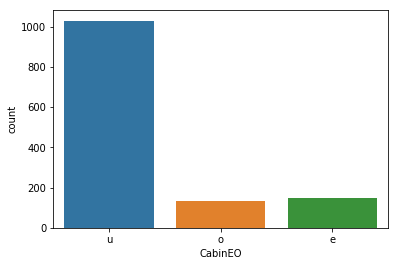

In [102]:
sns.countplot(x = "CabinEO", data = titanic)

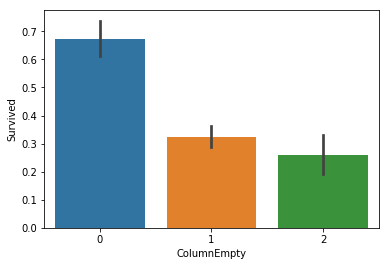

In [103]:
sns.barplot(x = "ColumnEmpty", y = "Survived", data = titanic)

In [104]:
def transform_categorical_values(df):
    
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    df['Agegroup'] = df['Agegroup'].map({'0-4': 0, '4-12': 1, '12-18': 2, '18-25': 3, '25-35': 4, '35-60': 5, '60-100': 6}).astype(int)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    df['CabinEO'] = df['CabinEO'].map({'e': 0, 'o': 1, 'u': 2}).astype(int)
    

transform_categorical_values(titanic)
print(titanic.head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  ... CabinD  CabinEO ColumnEmpty Company  \
0         A/5 21171   7.2500  ...      U        2           1       1   
1          PC 17599  71.2833  ...      C        1           0       1   
2  STON/O2. 3101282   7.9250  ...      U        2           1       0   
3   

In [105]:
# delete unneccesary attributes
def drop_attributes(df):
    return df.drop(['Ticket', 'Cabin', 'Name', 'Age', 'Fare', 'Lname', 'CabinD'], axis=1)

newtitanic = drop_attributes(titanic)
print(newtitanic)

      PassengerId  Survived  Pclass  Sex  SibSp  Parch  Embarked Dataset  \
0               1       0.0       3    0      1      0         0   train   
1               2       1.0       1    1      1      0         1   train   
2               3       1.0       3    1      0      0         0   train   
3               4       1.0       1    1      1      0         0   train   
4               5       0.0       3    0      0      0         0   train   
5               6       0.0       3    0      0      0         2   train   
6               7       0.0       1    0      0      0         0   train   
7               8       0.0       3    0      3      1         0   train   
8               9       1.0       3    1      0      2         0   train   
9              10       1.0       2    1      1      0         1   train   
10             11       1.0       3    1      1      1         0   train   
11             12       1.0       1    1      0      0         0   train   
12          

In [106]:
def split_sets(df):
    # select training part of dataset for rule making
    trainset = df.loc[df['Dataset'] == 'train']

    # select test part of dataset for later
    testset = df.loc[df['Dataset'] == 'test']
    
    trainset = trainset.drop(['Dataset'], axis = 1)
    testset = testset.drop(['Dataset'], axis = 1)
    
    return trainset, testset

newtrain, newtest = split_sets(newtitanic)[0], split_sets(newtitanic)[1]
# newtrain = newtrain.drop(['Dataset'])
# newtest = newtest.drop(['Dataset'])

print(newtrain)

     PassengerId  Survived  Pclass  Sex  SibSp  Parch  Embarked  CabinEO  \
0              1       0.0       3    0      1      0         0        2   
1              2       1.0       1    1      1      0         1        1   
2              3       1.0       3    1      0      0         0        2   
3              4       1.0       1    1      1      0         0        1   
4              5       0.0       3    0      0      0         0        2   
5              6       0.0       3    0      0      0         2        2   
6              7       0.0       1    0      0      0         0        0   
7              8       0.0       3    0      3      1         0        2   
8              9       1.0       3    1      0      2         0        2   
9             10       1.0       2    1      1      0         1        2   
10            11       1.0       3    1      1      1         0        0   
11            12       1.0       1    1      0      0         0        1   
12          

In [107]:
newtrain.describe()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,CabinEO,ColumnEmpty,Company,Companions,Alone,NamePrefix,Agegroup
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,0.523008,0.381594,0.361392,1.667789,0.971942,0.795735,0.904602,0.602694,0.813692,3.594837
std,257.353842,0.486592,0.836071,0.477990,1.102743,0.806057,0.635673,0.675133,0.618351,1.131184,1.613459,0.489615,1.143164,1.373397
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,446.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000
75%,668.500000,1.000000,3.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5.000000
max,891.000000,1.000000,3.000000,1.000000,8.000000,6.000000,2.000000,2.000000,2.000000,3.000000,10.000000,1.000000,5.000000,6.000000


In [108]:
# newtrain.describe(include=['O'])

newtrain.isnull().values.any()

False

In [109]:
X_train = newtrain.drop(["Survived", "PassengerId"], axis=1)
Y_train = newtrain["Survived"]
X_test  = newtest.drop(["Survived", "PassengerId"], axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape



# print(X_test.head())
# X_test.isnull().values.any()
# X_test.Faregroup.head()

((891, 13), (891,), (418, 13))

In [110]:
# Decision Tree
from sklearn.cluster import KMeans



decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
# print(decision_tree)
print(Y_pred)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(acc_decision_tree)


submission_tree = pd.read_csv('titanic/submission.csv')
submission_tree["Survived"] = Y_pred
print(submission_tree.head())

# csv.writer(submission_tree, dialect='excel', **fmtparams)
# clf = tree.DecisionTreeClassifier()
# iris = load_iris()
submission_tree.to_csv('tree_sub_try2.csv', index = False)

# decision_tree = decision_tree.fit(iris.data, iris.target)
tree.export_graphviz(decision_tree, out_file='tree.dot')    

print("Number of nodes:", decision_tree.tree_.node_count)

[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.

In [111]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test).astype(int)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(acc_gaussian)

submission_bayes = pd.read_csv('titanic/submission.csv')
submission_bayes["Survived"] = Y_pred
print(submission_bayes.head())

submission_tree.to_csv('bayes_sub_try3.csv', index = False)   

80.02
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


In [112]:
perc_correct = []

for i in range(5):
    X_train = newtrain.drop(["Survived", "PassengerId"], axis=1)
    X_train_k1, X_test_k, X_train_k2 = np.split(X_train, [int(0.2*i*len(Y_train)), int(((0.2*i) + 0.2)*len(Y_train))])
    X_train_k = pd.concat([X_train_k1, X_train_k2])

    Y_train = newtrain["Survived"]
    Y_train_k1, Y_test_k, Y_train_k2 = np.split(Y_train, [int(0.2*i*len(Y_train)), int(((0.2*i) + 0.2)*len(Y_train))])
    Y_train_k = pd.concat([Y_train_k1, Y_train_k2])

    decision_tree = DecisionTreeClassifier()
    decision_tree = decision_tree.fit(X_train_k, Y_train_k)
    Y_pred_k = decision_tree.predict(X_test_k)

    cor_count = 0
    for i in range(len(Y_pred_k)):
        if Y_pred_k[i] == Y_test_k.iloc[i]:
            cor_count += 1

    perc_correct.append(cor_count/len(Y_pred_k))
    
print("Average percentage correct decision tree: ", np.mean(perc_correct))
    
# acc_decision_tree = round(decision_tree.score(X_train, Y_test_k) * 100, 2)
# print(acc_decision_tree)

Average percentage correct decision tree:  0.7856317870817902


In [113]:
perc_correct = []

for i in range(5):
    X_train = newtrain.drop(["Survived", "PassengerId"], axis=1)
    X_train_k1, X_test_k, X_train_k2 = np.split(X_train, [int(0.2*i*len(Y_train)), int(((0.2*i) + 0.2)*len(Y_train))])
    X_train_k = pd.concat([X_train_k1, X_train_k2])

    Y_train = newtrain["Survived"]
    Y_train_k1, Y_test_k, Y_train_k2 = np.split(Y_train, [int(0.2*i*len(Y_train)), int(((0.2*i) + 0.2)*len(Y_train))])
    Y_train_k = pd.concat([Y_train_k1, Y_train_k2])

    gaussian = GaussianNB()
    gaussian.fit(X_train_k, Y_train_k)
    Y_pred_k = gaussian.predict(X_test_k).astype(int)

    cor_count = 0
    for i in range(len(Y_pred_k)):
        if Y_pred_k[i] == Y_test_k.iloc[i]:
            cor_count += 1

    perc_correct.append(cor_count/len(Y_pred_k))
    
print("Average percentage correct Bayes: ", np.mean(perc_correct))

Average percentage correct Bayes:  0.7900885066850796


In [114]:
def gender_prediction(df):
    
    # predict that females survive, males don't
    df["Pred"] = np.where(df["Sex"] == 1, 1, 0)

# check if prediction is correct (in training data)
def check_prediction(df):
    df["Correct"] = np.where(df.Pred == df.Survived, 1, 0)
    return df["Correct"].sum()

gender_prediction(newtrain)
check_prediction(newtrain)

gender_cor = list(newtrain["Correct"])
print(gender_cor)
# print(newtrain["Correct"])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [115]:
Y_pred = gaussian.predict(X_train).astype(int)
# acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
# print(Y_pred)

newtrain["Pred"] = Y_pred
    
print(check_prediction(newtrain)/len(newtrain))

gaussian_cor = list(newtrain["Correct"])
# print(gaussian_cor)

0.7946127946127947


In [116]:
Y_pred = decision_tree.predict(X_train).astype(int)
# acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
# print(Y_pred)

newtrain["Pred"] = Y_pred
    
print(check_prediction(newtrain))

tree_cor = list(newtrain["Correct"])
print(tree_cor)

793
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [117]:
scipy.stats.ttest_ind(gender_cor, gaussian_cor)

Ttest_indResult(statistic=-0.4073975146630254, pvalue=0.6837650402476824)

In [118]:
scipy.stats.ttest_ind(gender_cor, tree_cor)

Ttest_indResult(statistic=-5.976410531062318, pvalue=2.7491239747759546e-09)